<a href="https://colab.research.google.com/github/nellika/RL_Breakout_RAM/blob/master/breakout_ram.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

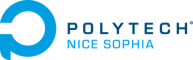

<h1>AI Course - RL assignment</h1>
<p><b>Prepared by</b> Zaida Brito Triana & Nelli Nyisztor</p>

The goal of thi assignment is to train an atari agent with one of the methods learnt during the semester.
Our chosen topic is: 
- Game: Breakout
- Observation type: RAM
- Method: Policy gradient
- Comparison: different reward strategies


**Disclaimer**: our work is based on the Andrej Karpathy's blog post, its keras implementation of mkturkcan, and the work of Michaël Trazzi was also a great input to our ideas.

The main difference is that they all worked with images thus, many of their functions have been replaced with our own work. Also, they focused specifically on the Atari game Pong with 2 actions and different rewarding options, whereas we experimented with an action space of 3 and additional rewarding methods.

We also implemented our own logging mechanism and tried different network architectures as well.

# Importing libraries

In [2]:
import os
import gym
import numpy as np
import datetime
import imageio
import matplotlib.pyplot as plt

from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import ReLU, BatchNormalization, TimeDistributed
from tensorflow.keras.layers import Activation, Flatten, Dense

# Parameter, variable initialization

In [16]:
# Script Parameters
gamma_old = 0.99
gamma = 0.9
update_frequency = 3
learning_rate = 0.001
resume = True

In [ ]:

# gym initialization
env = gym.make("Breakout-ram-v0")
observation = env.reset()

# Actions
A_FIRE = 1
A_RIGHT = 2
A_LEFT = 3

# RAM specific info
D_DOWN = 1
D_UP = 255

action_space = [A_FIRE, A_RIGHT, A_LEFT]
action_space_ext = [[1,0,0],[0,1,0],[0,0,1]]
number_of_inputs = len(action_space)

# initialization of variables used in the main loop
train_X, train_y, rewards = [],[],[]
xs, dlogps, probs = [],[],[]
running_rewards = []
all_rewards = []
all_scores = []
running_reward = None
running_score = None
reward_sum = 0
score_sum = 0
episode_nb = 0

# Util functions

## Discount reward experiments

The discount_reward function is one of the most important elements in our training.

At first, our approach was borrowed from Karpathy's work[2], so we used a discount rate 0.99 and reset the running_add after each non-zero value (discount_rewards_old).

This method rewards all moves gradually before a positive score and works very well until a certain point. After more than 1400 episodes, our moves are less random, we experience a growth in rewards episodes by episode, we reach scores above 10 from time to time and we reduced the number of 0 scores significantly.

In [ ]:
#  here comes the plot

The problem with this technique is that after a while our model realizes sees the following:


*   if after firing I go to the appropriate corner (by the 1000th episode it learns it very well), I will definitely score at least one
*   if I do not fire for long (getting 0 reward before the first 1), I got kind of nice scores just by doing random moves right or left

So slowly, our tricky model learns that it is better to wait for long before the first score. This is not advantegous because:


*   our episodes are getting longer and longer, increasing training time
*   this increased time is not increasing the useful training time
*   any move is rewarded before firing, this introduces confusion in the weights and decreases training efficiency





There are several ideas we came up with to correct this misbehaviour:


*   adding small negative rewards for unnecessary firing
*   adding small positive rewards for the right timing



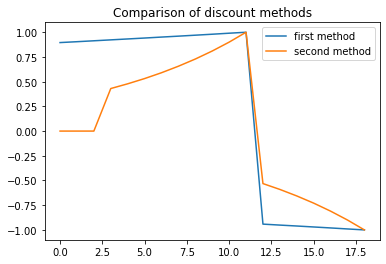

In [31]:
test_discount = np.array([0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,-1], dtype=np.float16)
x = range(0,test_discount.size)

r_old = discount_rewards_old(test_discount)
r = discount_rewards(test_discount)

plt.plot(x, r_old, label='first method')
plt.plot(x, r, label='second method')
plt.legend()
plt.title('Comparison of discount methods')
plt.show()

In [17]:
# based on Karpathy's work [2]
def discount_rewards_old(r):
    cnt = 0
    discounted_r = np.zeros_like(r)
    running_add = 0
    for t in reversed(range(0, r.size)):
        if r[t] != 0: running_add = 0
        running_add = running_add * gamma_old + r[t]
        discounted_r[t] = running_add
    return discounted_r

def discount_rewards(r):
    cnt = 0
    discounted_r = np.zeros_like(r)
    running_add = 0
    for t in reversed(range(0, r.size)):
        if r[t] != 0:
            running_add = 0
            cnt = 0
        else: cnt+=1
        if cnt > 8: running_add = 0
        running_add = running_add * gamma + r[t]
        discounted_r[t] = running_add
    return discounted_r

In [ ]:
k=np.array([0,0,0,0,0,0,0,0,1,0,0,0,1,0,-1,0,-0.01,0,0,0,0,1,0,0,0,-1], dtype=np.float16)
discount_rewards(k)

array([ 0.4304,  0.4783,  0.5312,  0.5903,  0.6562,  0.729 ,  0.81  ,
        0.9   ,  1.    ,  0.729 ,  0.81  ,  0.9   ,  1.    , -0.9   ,
       -1.    , -0.009 , -0.01  ,  0.6562,  0.729 ,  0.81  ,  0.9   ,
        1.    , -0.729 , -0.81  , -0.9   , -1.    ], dtype=float16)

In [ ]:
# 
def learning_model():
    model = Sequential()

    # hidden layer takes a pre-processed RAM vector as input (60 values)
    model.add(Dense(units=64,input_dim=60, activation='relu'))
    model.add(Dense(units=32, activation='relu'))

    # output layer
    model.add(Dense(units=3, activation='softmax'))
    opt = Adam(lr=learning_rate)
    model.compile(loss='categorical_crossentropy', optimizer=opt)

    if resume == True:
        print("using baseline")
        model.load_weights('breakout_model_checkpoint.h5')

    return model

# Main training loop

In [ ]:
model = learning_model()


# Initialize training

frames = [[],[],[],[],[],[],[],[]]
rews = [[],[],[],[],[],[],[],[]]
cnt = 0

fire_needed = True
extra_reward = 0
prev_direction = D_DOWN
prev_ball_height = 0
prev_prev_ball_height = 0
ball_bar_dist = 0
prev_ball_bar_dist = 0
prev_bar_location = 0
same_location_cnt = 0
penalty_added = False
lower_than_bar = False
prev_score_sum = 0 

observation, reward, done, info = env.step(1)

# Create log file with timestamp
file_name = "log_" + datetime.datetime.now().strftime('%Y%m%d_%H_%M') + ".txt"
f = open(file_name, "x")
f.close()

# Check if rewards are given in the correct situations
debug = False
debugx = False

while True:

    if(episode_nb == 1000 or 
       episode_nb == 500 or 
       episode_nb == 300 or 
       episode_nb == 200 or 
       episode_nb == 100 or 
       episode_nb == 75 or 
       episode_nb == 50 or 
       episode_nb == 0): debug_img = True
    else: debug_img = False

    if render: 
        env.render()

    if ((observation[101] == 0 and observation[100] == 0) or
            observation[105] == 0):
            # needed for round start init
            prev_direction = D_UP
            prev_ball_height = 0
            fire_needed = True
            lower_than_bar = False

    # Prepocess observation
    # We know form observations and other resources[3] that the 'useful' range of the RAM is
    # in between the position 50 and 110, furthermore to avoid infinite values in the loss function,
    # we decided to normalize the values, thus the division by 255
    x = observation[50:110]/255

    # Predict probabilities from the Keras model
    aprob = ((model.predict(x.reshape([1,x.shape[0]]), batch_size=1).flatten()))

    #Append features and labels for the episode-batch
    xs.append(x)
    probs.append((model.predict(x.reshape([1,x.shape[0]]), batch_size=1).flatten()))
    aprob = aprob/np.sum(aprob)
    action = np.random.choice(number_of_inputs, 1, p=aprob)[0]


    # (1) Reward experiment: Can we teach our model earlier, when is the right moment to fire?
    if not fire_needed and action == 0:
        if debug: print(str(len(rewards)) + " >> no fire needed, but fired")
        extra_reward += 0 #-0.01
    elif fire_needed:
        if debug: print(str(len(rewards)) + " >> fire needed")
        if action != 0:
            extra_reward += 0
        fire_needed = False

    y = np.zeros([number_of_inputs])
    y[action] = 1

    # print(action)
    dlogps.append(np.array(y).astype('float32') - aprob)
    observation, reward, done, info = env.step(action_space[action])

    # (2) Reward experiment: Will an extra reward on the bar vs. ball meetup have any effect on our model?
    if observation[103] > 250 and prev_direction == D_DOWN:
    # if we hit the bar it is halfway a score ;)
        if debug: print(str(len(rewards)) + " >> hit the bar")
        extra_reward += 1

    # 72 bar, 99 ball
    dist = int(observation[72]) - int(observation[99])
    ball_bar_dist = abs(dist)

    if observation[72] == prev_bar_location: same_location_cnt += 1
    prev_bar_location = observation[72]

    # (3) Reward experiment: Can we prevent the bar being stuck in one corner?
    if same_location_cnt > 5:
        if debugx: print(str(len(rewards)) + " >> same location")
        extra_reward += 0 # -0.02
        same_location_cnt = 0

    # (4) Reward experiment: Is the advancement influenced in case we punish all situations,
    #                        where the bar is too far from the ball in a falling position?
    if observation[103] == 1 and prev_ball_bar_dist < ball_bar_dist and not lower_than_bar:
        if((dist > 40 and action != 2) or
            (dist < -40 and action != 1)):
            extra_reward += 0 # -0.02
            if debug: print(str(len(rewards)) + " >> distance too big")
        
    prev_ball_bar_dist = ball_bar_dist

    # (5) Reward experiment: Introducing negative reward in case we loose a life
    # if the ball is lower than the bar
    if (prev_prev_ball_height > 176 and
        prev_ball_height > 178 and
        observation[101] > 181 and
        not penalty_added):
            if debug: print(str(len(rewards)) + " >> lower than the bar")
            extra_reward += -1
            # rewards[len(rewards)-1] += -1
            penalty_added = True
            lower_than_bar = True

    if observation[101] < prev_ball_height:
        if debug: print(str(len(rewards)) + " >> going up again")
        # needed for round start init
        penalty_added = False

    # (6) Reward experiment: scoring 4 is easy... just stay in the corner. Can we encourage higher scores like this?
    # if prev_score_sum < score_sum and score_sum > 4 and score_sum < 100:
    #     if debugx: print(str(len(rewards)) + " >> score more than 4")
    #     extra_reward += 0.5

    prev_prev_ball_height = prev_ball_height
    prev_ball_height = observation[101]
    prev_direction = observation[103]


    # Check agent performance in different state
    if debug_img:
        frames[cnt].append(observation)
        im = env.unwrapped._get_image()
        imageio.imwrite("img/"+str(cnt)+"/"+str(cnt)+"_im"+str(len(frames[cnt])-1)+".jpg",im)
        rews[cnt].append(reward + extra_reward)

    # keeping track of scores and rewards
    prev_score_sum = score_sum 
    score_sum += reward
    reward_sum += extra_reward

    rewards.append(extra_reward)
    extra_reward = 0
        


    if done:
        episode_nb += 1
        if debug_img: cnt += 1

        epx = np.vstack(xs)
        epdlogp = np.vstack(dlogps)
        epr = np.vstack(rewards)
        discounted_epr = discount_rewards(epr)
        discounted_epr = discounted_epr - np.mean(discounted_epr)
        discounted_epr /= np.std(discounted_epr)
        epdlogp *= discounted_epr

        # Slowly prepare the training batch
        train_X.append(xs) 
        train_y.append(epdlogp)
        xs,dlogps,rewards = [],[],[]

        # Periodically update the model
        if episode_nb % update_frequency == 0: 
            y_train = probs + learning_rate * np.squeeze(np.vstack(train_y))
            model.train_on_batch(np.squeeze(np.vstack(train_X)), y_train)

            # Clear the batch
            train_X = []
            train_y = []
            probs = []

            # Save a checkpoint of the model
            os.remove('breakout_model_checkpoint.h5') if os.path.exists('breakout_model_checkpoint.h5') else None
            model.save_weights('breakout_model_checkpoint.h5')

        running_reward = reward_sum if running_reward is None else running_reward * 0.99 + reward_sum * 0.01
        running_rewards.append(running_reward)
        all_rewards.append(reward_sum)
        all_scores.append(score_sum)

        # Save log after each episode
        f = open(file_name, "a")
        f.write(datetime.datetime.now().strftime('%Y%m%d %H:%M:%S') + ' >> Episode: %d. Total Episode Reward: %.2f. Running Mean: %.2f. Score: %.2f\n' % (episode_nb, reward_sum, running_reward, score_sum))
        f.close()

        # Print episode results
        print('Episode: %d. Total Episode Reward: %.2f. Running Mean: %.2f. Score: %.2f' % (episode_nb, reward_sum, running_reward, score_sum))
        reward_sum = 0
        score_sum = 0
        observation = env.reset()

using baseline


UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('float64') to dtype('int64') with casting rule 'same_kind'

# Additional trials, sanity checks

[-4 -3 -2 -1]
[-4. -3. -2. -1.]


UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('float64') to dtype('int64') with casting rule 'same_kind'

In [ ]:
probs + learning_rate * np.squeeze(np.vstack(train_y))

In [ ]:
aprob

array([nan, nan, nan], dtype=float32)

In [ ]:
print(frames[1][61])
print(frames[1][62])
print(frames[1][63])
print(frames[1][64])

In [ ]:
print(rews[1][161])
print(rews[1][162])
print(rews[1][163])
print(rews[1][164])

In [ ]:
# observation, reward, done, info = env.step(action_space[action])
observation, reward, done, info = env.step(action_space[action])
x = observation[50:110]/256

#Predict probabilities from the Keras model
aprob = ((model.predict(x.reshape([1,x.shape[0]]), batch_size=1).flatten()))

print(aprob)
#Append features and labels for the episode-batch
xs.append(x)
probs.append((model.predict(x.reshape([1,x.shape[0]]), batch_size=1).flatten()))
aprob = aprob/np.sum(aprob)
action = np.random.choice(number_of_inputs, 1, p=aprob)[0]
print(action, action_space[action])

# References

- [1] Michaël Trazzi [Spinning Up a Pong AI With Deep Reinforcement Learning](https://blog.floydhub.com/spinning-up-with-deep-reinforcement-learning/)
- [2] Andrej Karpathy [Deep Reinforcement Learning: Pong from Pixels](http://karpathy.github.io/2016/05/31/rl)
- [3] philoxenic [Learning Breakout From RAM – Part 1](https://www.codeproject.com/Articles/5271949/Learning-Breakout-From-RAM-Part-1)
- [4] mkturkcan [Keras-Pong](https://github.com/mkturkcan/Keras-Pong/blob/master/keras_pong.py)